In [1]:
import re
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import warnings
warnings.simplefilter("ignore") 

In [2]:
df = pd.read_excel('Bangalore_House_Rent_Data_Address_Cleaned.xlsx')
df_copy = df.copy()
df_copy.columns

Index(['Property_ID', 'Region', 'Bedroom', 'Bathroom', 'Balcony',
       'Additional_rooms', 'Area', 'Facing', 'Furnishing', 'Rating', 'Address',
       'Locality', 'Nearby', 'Power_backup', 'Parking', 'Charges',
       'Posted_By_and_On', 'Age', 'Pet_friendly', 'Floor', 'Avaliable_from',
       'Available_for', 'Type', 'Advance', 'Rent'],
      dtype='object')

In [3]:
df_copy = df_copy.dropna(subset=['Rent' , 'Bathroom' , 'Bedroom' , 'Available_for' , 'Furnishing'] , how = 'any').reset_index(drop= True)

In [4]:
def Pie_Chart(column_name):

    plt.figure(figsize=(6, 4))
    
    counts = df_copy[column_name].value_counts()
    percentages = (counts / counts.sum()) * 100
    
    ax = counts.plot(kind='pie', autopct='%0.1f%%', startangle=90)
    
    legend_labels = [f"{label}: {percent:.2f}%" for label, percent in zip(counts.index, percentages)]
    
    plt.legend(legend_labels, title=column_name , loc="upper left", bbox_to_anchor=(1.3, 1))
    plt.ylabel('')
    plt.show()

### **Data Cleaning Process Summary**  

1. **Bedroom Column**:  
   - Extracting numeric values from the 'Bedroom' column, replaced missing values with `0`, and converted the data to `float`.  
   - Visualizing the distribution using a pie chart.  
   - Filtering the dataset to include entries with bedroom counts less than or equal to 6.  

2. **Bathroom Column**:  
   - Extracting numeric values, handled missing data by replacing it with `0`, and converted to `float`.  
   - Plotting a pie chart for distribution analysis.  
   - Retaining entries where the bathroom count was less than or equal to 6.  

3. **Balcony Column**:  
   - Extracting numeric values (including formats like '2+'), replaced missing values with `0`.  
   - Displaying the distribution using a pie chart.  

4. **Additional Rooms Column**:  
   - Counting the number of additional rooms by splitting the string data. Missing values were treated as `0`.  
   - Visualizing the distribution with a pie chart.  
   - Removing entries where the number of additional rooms was exactly 5.  

5. **Data Dropping Criteria**:  
   - Based on pie chart observations, entries contributing less than 0.1% to the overall distribution were removed.  

In [5]:
df_copy['Bedroom'] = df_copy['Bedroom'].str.findall(r'^\d+').str.get(0).fillna(0).astype(float)

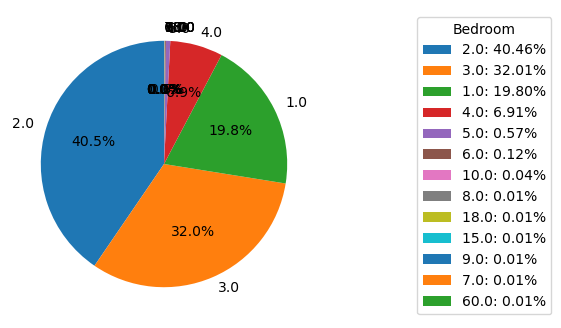

In [6]:
Pie_Chart('Bedroom')

In [7]:
df_copy = df_copy.iloc[np.array(df_copy['Bedroom'] <= 6) , :].reset_index(drop = True)

In [8]:
df_copy['Bathroom'] = df_copy['Bathroom'].str.findall(r'^\d+').str.get(0).fillna(0).astype(float)

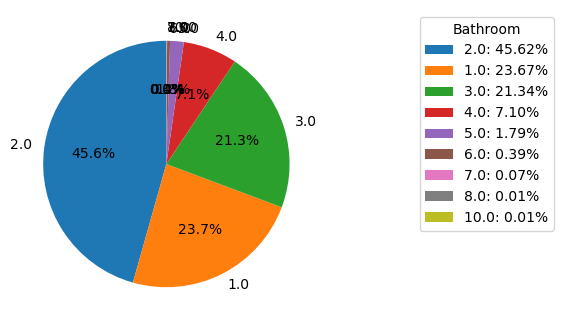

In [9]:
Pie_Chart('Bathroom')

In [10]:
df_copy = df_copy.iloc[np.array(df_copy['Bathroom'] <= 6) , :].reset_index(drop = True)

In [11]:
df_copy['Balcony'] = df_copy['Balcony'].str.findall(r'^\d+\+?').str.get(0).fillna(0)

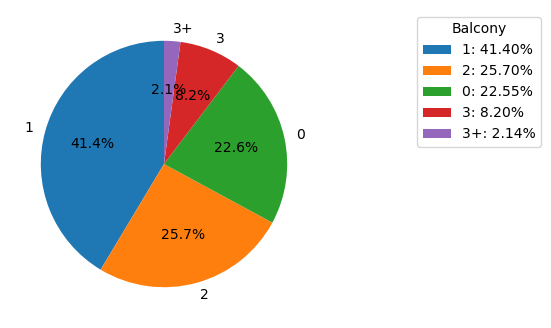

In [12]:
Pie_Chart('Balcony')

In [13]:
df_copy['Additional_rooms'] = df_copy['Additional_rooms'].apply(lambda x: len(x.split(',')) if pd.notna(x) else None).fillna(0)

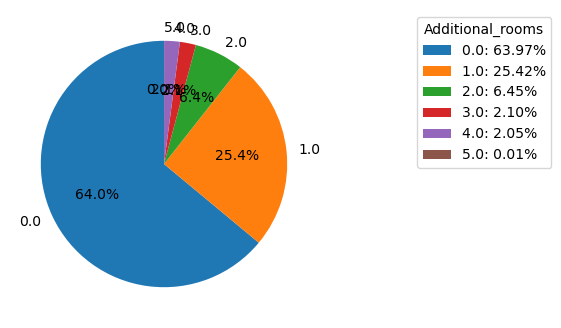

In [14]:
Pie_Chart('Additional_rooms')

In [15]:
df_copy = df_copy.iloc[np.array(df_copy['Additional_rooms'] != 5) , :].reset_index(drop = True)

#### **Dropping 'Price on Request' Entries in Rent column**

In [16]:
df_copy = df_copy.iloc[~np.array(df_copy['Rent'] == 'Price on Request') , :].reset_index(drop = True)

### **Rent Column Processing**  

- Defining the `Lac` function to **convert rent values**:  
  - If the value contains **'Lac'**, it multiplies the numeric part by **100,000** to convert it to a standard numerical format.  
  - If the value is already numeric, it simply converts it to a **float**.  
- Cleaned the **'Rent'** column by:  
  - Removing commas from values.  
  - Applying the `Lac` function to standardize all rent amounts into numerical values.

In [17]:
def Lac(x):
    if 'Lac' in x:
        return np.round(float(re.search(r'[\d\.]+' , x).group()) * 100000 , 1)
    else:
            return np.round(float(x) , 1)

In [18]:
df_copy['Rent'] = df_copy['Rent'].str.split(',').apply(lambda x : ''.join(x)).apply(lambda x : Lac(x))

### **Rent Outlier Removal Summary**  

1. **Initial Visualization**:  
   - Plotting the original **rent distribution** using a histogram with a KDE curve.  

2. **Log Transformation**:  
   - Applying `np.log1p` to the **'Rent'** column to handle skewness and stabilize variance for outlier detection.  

3. **Outlier Detection and Removal**:  
   - Calculating the **Interquartile Range (IQR)** within different groupings to determine lower and upper bounds for acceptable rent values.  
   - Grouping hierarchy for applying bounds:  
     - **Locality, Type, Bedroom**.  
     - If groups had **<10 listings**, re-applied bounds with **Locality, Bedroom**.  
     - If still **<25 listings**, re-applied bounds with **Region, Type, Bedroom**.  
     - If still **<50 listings**, re-applied bounds with **Region, Bedroom**.  
   - Converting the bounds back from the logarithmic scale using `np.expm1`.  
   - Filtering out entries where **'Rent'** was outside the computed bounds.  

4. **Post-Filtering Visualization**:  
   - Plotting the rent distribution **after outlier removal** for comparison.  
   - Displaying **boxplots** of rent by region, both before and after filtering, to visualize the impact of outlier removal.  

5. **Final Dataframe**:  
   - Returning the filtered DataFrame after dropping helper columns (`Log_Rent`, `lower_bound`, `upper_bound`, `num_houses`).

Groups with <10 listings: 3404
Groups with <25 listings: 2751
Groups with <50 listings: 632


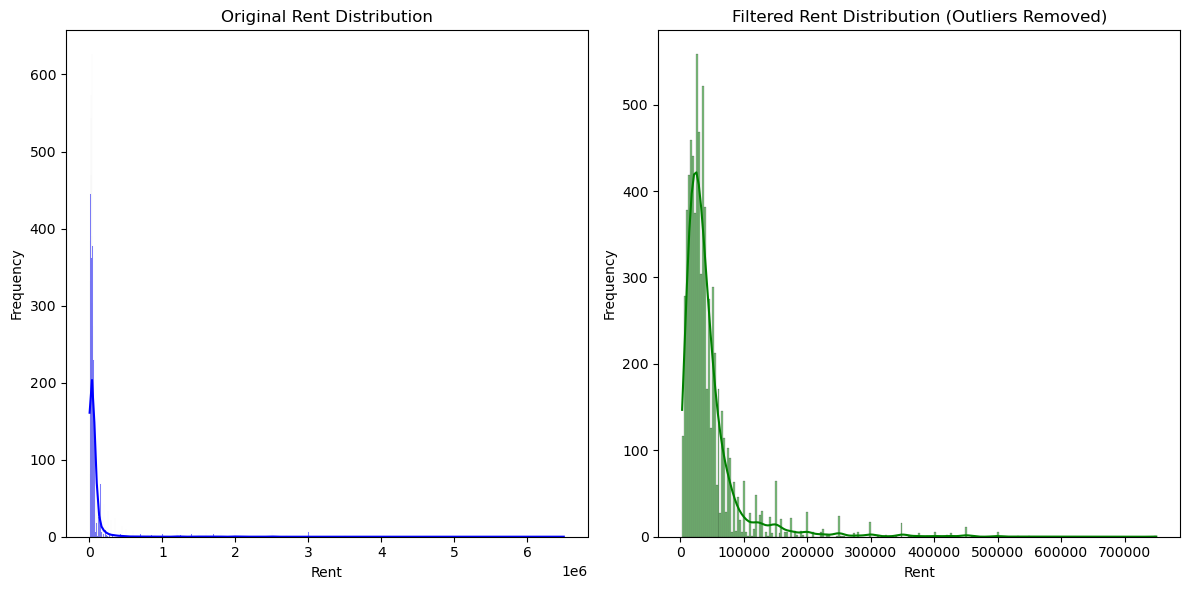

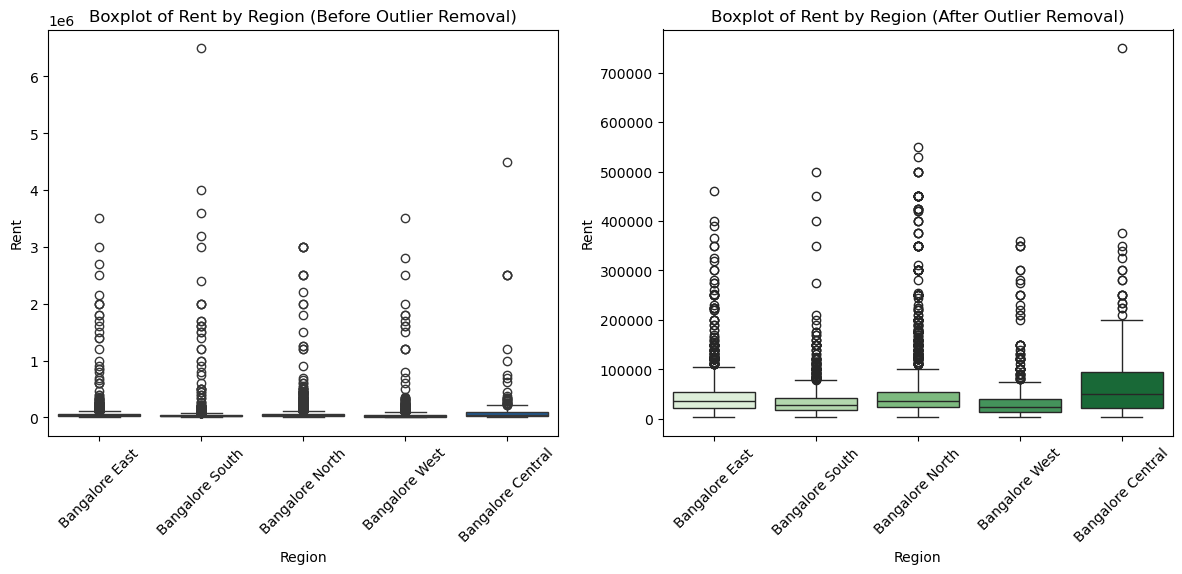

In [19]:
def remove_rent_outliers(df):
    df = df.copy()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df['Rent'], kde=True, color='blue', label='Original')
    plt.title('Original Rent Distribution')
    plt.xlabel('Rent')
    plt.ylabel('Frequency')
    
    df['Log_Rent'] = np.log1p(df['Rent'])
    
    def apply_bounds(df, group_cols):
        q1 = df.groupby(group_cols)['Log_Rent'].transform(lambda x: x.quantile(0.25))
        q3 = df.groupby(group_cols)['Log_Rent'].transform(lambda x: x.quantile(0.75))
        iqr = q3 - q1
        df['lower_bound'] = q1 - 1.5 * iqr
        df['upper_bound'] = q3 + 1.5 * iqr
        df['num_houses'] = df.groupby(group_cols)['Log_Rent'].transform('count')
        return df
    
    df = apply_bounds(df, ['Locality', 'Type', 'Bedroom'])
    small_idx_10 = df[df['num_houses'] < 10].index
    print(f"Groups with <10 listings: {len(small_idx_10)}")
    
    df_new = apply_bounds(df, ['Locality', 'Bedroom'])
    df.loc[small_idx_10, ['lower_bound', 'upper_bound', 'num_houses']] = df_new.loc[
        small_idx_10, ['lower_bound', 'upper_bound', 'num_houses']
    ]
    small_idx_25 = df.loc[small_idx_10][df.loc[small_idx_10]['num_houses'] < 25].index
    print(f"Groups with <25 listings: {len(small_idx_25)}")
    
    df_new = apply_bounds(df, ['Region', 'Type', 'Bedroom'])
    df.loc[small_idx_25, ['lower_bound', 'upper_bound', 'num_houses']] = df_new.loc[
        small_idx_25, ['lower_bound', 'upper_bound', 'num_houses']
    ]
    small_idx_50 = df.loc[small_idx_25][df.loc[small_idx_25]['num_houses'] < 50].index
    print(f"Groups with <50 listings: {len(small_idx_50)}")
    
    df_new = apply_bounds(df, ['Region' , 'Bedroom'])
    df.loc[small_idx_50, ['lower_bound', 'upper_bound', 'num_houses']] = df_new.loc[
        small_idx_50, ['lower_bound', 'upper_bound', 'num_houses']
    ]
    
    df['lower_bound'] = np.expm1(df['lower_bound'])
    df['upper_bound'] = np.expm1(df['upper_bound'])
    
    df_filtered = df[(df['Rent'] >= df['lower_bound']) & (df['Rent'] <= df['upper_bound'])]
    
    plt.subplot(1, 2, 2)
    sns.histplot(df_filtered['Rent'], kde=True, color='green', label='Filtered')
    plt.title('Filtered Rent Distribution (Outliers Removed)')
    plt.xlabel('Rent')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Region', y='Rent', data=df, palette='Blues')
    plt.xticks(rotation=45)
    plt.title('Boxplot of Rent by Region (Before Outlier Removal)')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Region', y='Rent', data=df_filtered, palette='Greens')
    plt.xticks(rotation=45)
    plt.title('Boxplot of Rent by Region (After Outlier Removal)')
    
    plt.tight_layout()
    plt.show()
    
    return df_filtered.drop(columns=['Log_Rent', 'lower_bound', 'upper_bound', 'num_houses'])

df_copy = remove_rent_outliers(df_copy)

In [20]:
df_copy['Rent'].describe().round(2)

count      7216.00
mean      45154.28
std       51397.23
min        3000.00
25%       20000.00
50%       32000.00
75%       50000.00
max      750000.00
Name: Rent, dtype: float64

In [21]:
df_copy.rename(columns= {'Area' : 'Area (sq.ft)'} , inplace=True)

### **Area Outlier Removal Summary**  

1. **Initial Visualization**:  
   - Plotting the original distribution of **'Area (sq.ft)'** using a histogram with a KDE curve.  

2. **Rent Range Categorization**:  
   - Creating rent range categories to enhance the granularity of outlier detection:  
     - **'Rent_Range_Locality'**: Divided rent values into up to **20 bins** within each locality.  
     - **'Rent_Range_Region'**: Divided rent values into up to **10 bins** within each region.  
     - **'Rent_Range_Overall'**: Divided all rent values into **10 bins** overall.  

3. **Log Transformation**:  
   - Applying `np.log1p` to the **'Area (sq.ft)'** column for better handling of skewness.  

4. **Outlier Detection**:  
   - Calculating **IQR (Interquartile Range)** and bounds for outlier detection at different grouping levels:  
     - **Locality & Rent Range** (if group size ≥ 10).  
     - **Region & Rent Range** (if group size ≥ 10).  
     - **Overall Rent Range** for smaller groups.  
   - Computing **lower and upper bounds** for each group.  
   - Converting bounds back from the logarithmic scale using `np.expm1`.  

5. **Outlier Removal**:  
   - Filtering out entries where **'Area (sq.ft)'** values were outside the computed bounds.  

6. **Post-Filtering Visualization**:  
   - Plotting the distribution of **'Area (sq.ft)'** after outlier removal.  
   - Displaying **boxplots** by region to visualize the impact of outlier removal.  

7. **Final Dataframe**:  
   - Returning the cleaned DataFrame after dropping helper columns used for calculation.

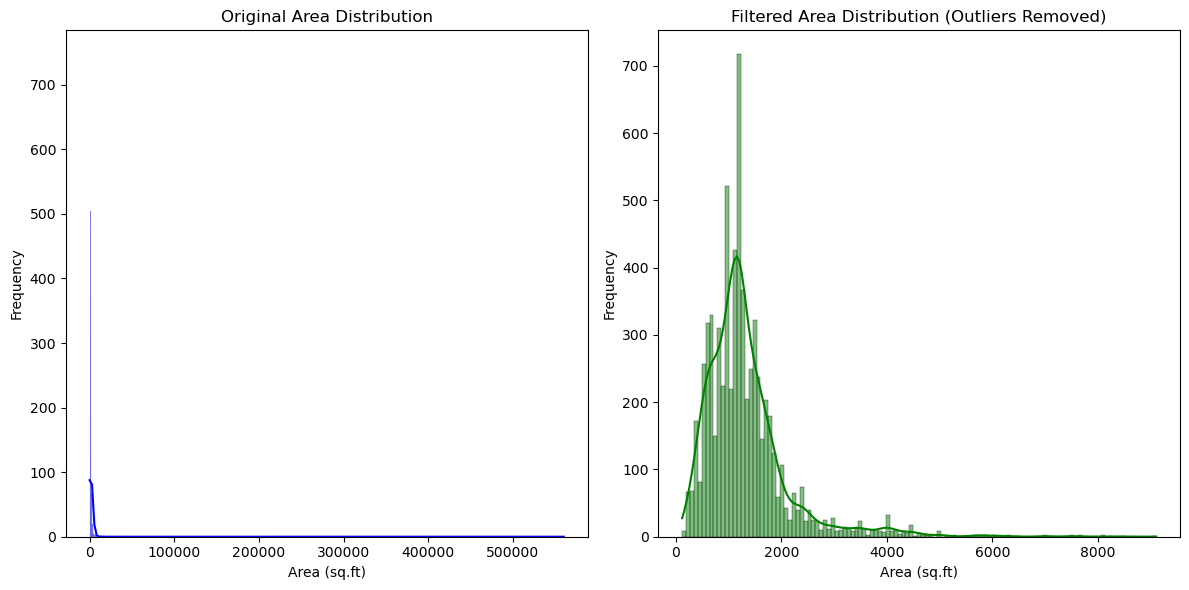

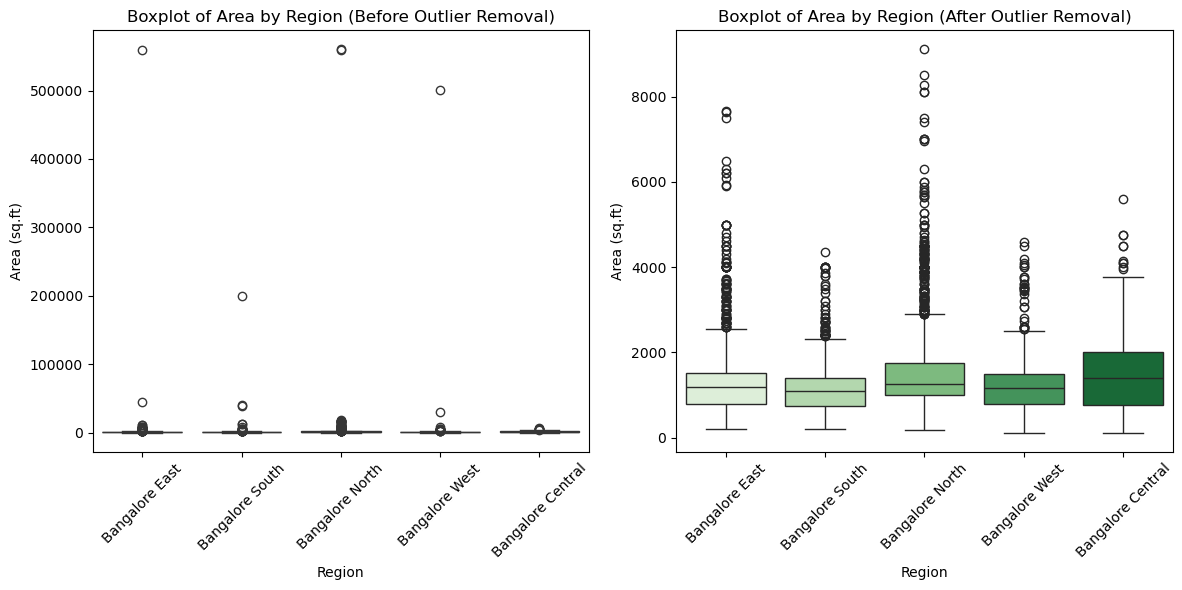

In [22]:
def remove_outliers(df_copy):
    df = df_copy.copy()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df['Area (sq.ft)'], kde=True, color='blue', label='Original')
    plt.title('Original Area Distribution')
    plt.xlabel('Area (sq.ft)')
    plt.ylabel('Frequency')
    
    df['Rent_Range_Locality'] = df.groupby('Locality')['Rent'].transform(
        lambda x: pd.qcut(x, q=min(20, x.nunique()), duplicates='drop', labels=False) if x.nunique() > 1 else 0
    )

    df['Rent_Range_Region'] = df.groupby('Region')['Rent'].transform(
        lambda x: pd.qcut(x, q=min(10, x.nunique()), duplicates='drop', labels=False) if x.nunique() > 1 else 0
    )

    df['Rent_Range_Overall'] = pd.qcut(
        df['Rent'], q=min(10, df['Rent'].nunique()), duplicates='drop', labels=False
    )

    df['Log_Area'] = np.log1p(df['Area (sq.ft)'])

    q1_locality = df.groupby(['Locality', 'Rent_Range_Locality'])['Log_Area'].transform(lambda x: x.quantile(0.25))
    q3_locality = df.groupby(['Locality', 'Rent_Range_Locality'])['Log_Area'].transform(lambda x: x.quantile(0.75))
    iqr_locality = q3_locality - q1_locality

    q1_region = df.groupby(['Region', 'Rent_Range_Region'])['Log_Area'].transform(lambda x: x.quantile(0.25))
    q3_region = df.groupby(['Region', 'Rent_Range_Region'])['Log_Area'].transform(lambda x: x.quantile(0.75))
    iqr_region = q3_region - q1_region

    q1_whole = df.groupby('Rent_Range_Overall')['Log_Area'].transform(lambda x: x.quantile(0.25))
    q3_whole = df.groupby('Rent_Range_Overall')['Log_Area'].transform(lambda x: x.quantile(0.75))
    iqr_whole = q3_whole - q1_whole

    df['num_houses_locality'] = df.groupby(['Locality', 'Rent_Range_Locality'])['Log_Area'].transform('count')
    df['num_houses_region'] = df.groupby(['Region', 'Rent_Range_Region'])['Log_Area'].transform('count')

    df['lower_bound'] = np.where(
        df['num_houses_locality'] >= 10,
        q1_locality - 1.5 * iqr_locality,
        np.where(
            df['num_houses_region'] >= 10,
            q1_region - 1.5 * iqr_region,
            q1_whole - 1.5 * iqr_whole
        )
    )

    df['upper_bound'] = np.where(
        df['num_houses_locality'] >= 10,
        q3_locality + 1.5 * iqr_locality,
        np.where(
            df['num_houses_region'] >= 10,
            q3_region + 1.5 * iqr_region,
            q3_whole + 1.5 * iqr_whole
        )
    )

    df['lower_bound'] = np.expm1(df['lower_bound'])
    df['upper_bound'] = np.expm1(df['upper_bound'])

    df_filtered = df[(df['Area (sq.ft)'] >= df['lower_bound']) & (df['Area (sq.ft)'] <= df['upper_bound'])]

    df_filtered = df_filtered.drop(columns=['lower_bound', 'upper_bound', 'num_houses_locality', 'num_houses_region', 'Log_Area'])
    
    plt.subplot(1, 2, 2)
    sns.histplot(df_filtered['Area (sq.ft)'], kde=True, color='green', label='Filtered')
    plt.title('Filtered Area Distribution (Outliers Removed)')
    plt.xlabel('Area (sq.ft)')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Region', y='Area (sq.ft)', data=df, palette='Blues')
    plt.xticks(rotation=45)
    plt.title('Boxplot of Area by Region (Before Outlier Removal)')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='Region', y='Area (sq.ft)', data=df_filtered, palette='Greens')
    plt.xticks(rotation=45)
    plt.title('Boxplot of Area by Region (After Outlier Removal)')
    
    plt.tight_layout()
    plt.show()
    
    return df_filtered

df_copy = remove_outliers(df_copy)

In [23]:
df_copy['Area (sq.ft)'].describe()

count    6790.000000
mean     1327.784919
std       824.083239
min       120.000000
25%       850.000000
50%      1200.000000
75%      1554.750000
max      9108.000000
Name: Area (sq.ft), dtype: float64

In [24]:
df_copy['Rent'].describe()

count      6790.000000
mean      44348.809278
std       47315.388182
min        3000.000000
25%       20000.000000
50%       32000.000000
75%       50000.000000
max      500000.000000
Name: Rent, dtype: float64

#### Extracting brokerage details from the `'Advance'` column based on either a percentage of rent or a fixed amount. It ensures all brokerage values are numeric.

In [25]:
df_copy['Brokerage'] = df_copy['Advance'].str.findall(r'Brokerage₹\s[\d\,]+|Brokerage\d+\%').str.get(0)

In [26]:
def Brokerage(x):
    try:
        if '%' in x['Brokerage']:
            return np.round((float(re.search(r'\d+' , x['Brokerage']).group()) * x['Rent'])/100 , 1)
        else:
            return np.round(float(''.join(re.search(r'[\d\,]+' , x['Brokerage']).group().split(','))) , 1)
    except:
        return 0

In [27]:
df_copy['Brokerage'] = df_copy.apply(Brokerage , axis=1)

In [28]:
df_copy['Brokerage'].describe().round(2)

count       6790.00
mean       23506.06
std        49925.97
min            0.00
25%            0.00
50%            0.00
75%        35000.00
max      1400000.00
Name: Brokerage, dtype: float64

In [29]:
df_copy['Rent'][df_copy['Brokerage'] == 1400000]

4857    140000.0
Name: Rent, dtype: float64

#### Extracting deposit details from the `'Advance'` column based on either a fixed value or a multiple of the rent in months. It ensures all deposit values are numeric.

In [30]:
df_copy['Deposit'] = df_copy['Advance'].str.findall(r'Deposit₹\s[\d\,]+|Deposit\d+\smonths').str.get(0)

In [31]:
def Deposit(x):
    try:
        if 'months' in x['Deposit']:
            return np.round((float(re.search(r'\d+' , x['Deposit']).group()) * x['Rent']) , 1)
        else:
            return np.round(float(''.join(re.search(r'[\d\,]+' , x['Deposit']).group().split(','))) , 1)
    except:
        return 0

In [32]:
df_copy['Deposit'] = df_copy.apply(Deposit , axis=1)

In [33]:
df_copy['Deposit'].describe().round(2)

count       6790.00
mean      212111.91
std       349145.79
min            0.00
25%            0.00
50%       127000.00
75%       250000.00
max      4675000.00
Name: Deposit, dtype: float64

In [34]:
df_copy['Rent'][df_copy['Deposit'] == 4675000]

5591    425000.0
Name: Rent, dtype: float64

#### Extracting maintenance charges from the `'Advance'` column, removes commas, converts them to numeric values.

In [35]:
def Maintenance(x):
    try: 
        return np.round(float(''.join(x)) , 1)
    except:
        return 0

In [36]:
df_copy['Maintenance'] = df_copy['Advance'].str.findall(r'Maintenance₹\s[\d\,]+').str.get(0).str.findall(r'[\d\,]+').str.get(0).str.split(',').apply(Maintenance)

In [37]:
df_copy = df_copy.iloc[np.array(df_copy['Maintenance'] < df_copy['Rent']) , :].reset_index()

In [38]:
df_copy['Maintenance'].describe().round(2)

count     6785.00
mean      1533.62
std       3731.02
min          0.00
25%          0.00
50%          0.00
75%       1000.00
max      55000.00
Name: Maintenance, dtype: float64

In [39]:
df_copy['Rent'][df_copy['Maintenance'] == 55000]

7    135000.0
Name: Rent, dtype: float64

#### Removing the `'Advance'` column from the DataFrame after extracting all relevant information.

In [40]:
df_copy.drop(columns=['Advance'] , inplace= True) 

#### Extracting the **type of poster** (Owner, Dealer, or Builder) from the `'Posted_By_and_On'` column.

In [41]:
df_copy['Posted_By'] = df_copy['Posted_By_and_On'].str.split(' ').str.get(0)

In [42]:
df_copy.drop(columns = 'Posted_By_and_On' , inplace=True)

#### Extracting the number of **covered** and **open parking spaces** from the `'Parking'` column, converts them to numeric values, and calculates the total parking spaces. Missing values are handled by filling them with `0`.

In [43]:
df_copy['Covered_Parking'] = df_copy['Parking'].str.findall(r'\d+\sCovered').str.get(0).str.findall(r'\d+').str.get(0).fillna(0).astype('float')

In [44]:
df_copy['Open_Parking'] = df_copy['Parking'].str.findall(r'\d+\sOpen').str.get(0).str.findall(r'\d+').str.get(0).fillna(0).astype('float')

In [45]:
df_copy['Total_Parking'] = df_copy['Open_Parking'] + df_copy['Covered_Parking']

In [46]:
df_copy = df_copy.iloc[np.array(df_copy['Open_Parking'] <= 5) & np.array(df_copy['Covered_Parking'] <= 6), :].reset_index(drop = True)

#### Removing the `'Parking'` column after extracting covered, open, and total parking spaces.

In [47]:
df_copy.drop(columns= ['Parking'] , inplace=True)

#### Converting the `'Available_for'` column into three binary columns indicating whether a listing is available for families, women bachelors, or men bachelors. It then removes the original column.

In [48]:
df_copy['Available_for'].value_counts()

Available_for
Family Only                        3229
All                                2939
Family , Bachelors (Women Only)     233
Bachelors (Men/Women)               194
Family , Bachelors (Men Only)       117
Bachelors (Men Only)                 48
Bachelors (Women Only)               19
Name: count, dtype: int64

In [49]:
df_copy['Available_for_Family'] = df_copy['Available_for'].apply(lambda x : 1 if x in ['Family Only' , 'All' , 'Family , Bachelors (Women Only)' , 'Family , Bachelors (Men Only)'] else 0)

In [50]:
df_copy['Available_for_Women_Bachelors'] = df_copy['Available_for'].apply(lambda x : 1 if x in ['All' , 'Family , Bachelors (Women Only)' , 'Bachelors (Women Only)' , 'Bachelors (Men/Women)'] else 0)

In [51]:
df_copy['Available_for_Men_Bachelors'] = df_copy['Available_for'].apply(lambda x : 1 if x in ['All' , 'Family , Bachelors (Men Only)' , 'Bachelors (Men Only)' , 'Bachelors (Men/Women)'] else 0)

In [52]:
df_copy.drop(columns=['Available_for'] , inplace=True)

#### Categorizing nearby places into different categories (e.g., hospitals, banks, public places, education centers, and transportation depots) using regex patterns. It applies a function to count matching occurrences in each row of the `'Nearby`' column and creates new columns for each category in **df_copy**.

In [53]:
def categorize_nearby(nearby_list, pattern, category_name):
    count = 0
    for place in ast.literal_eval(nearby_list):
        if re.search(pattern, place):
            count += 1
    return count

patterns = {
    "Hospitals_and_Clinics_Nearby": r'(?:[Cc]linic[s]?|[Hh]ospital[s]?|[Mm]edical|[Hh]ealth|[Pp]harmacy|[Nn]ursing|[Hh]ealthcare|[Pp]olyclinic|[Ss]urgical|[Dd]ispensary|[Dd]octor|[Mm]edic|[Dd]ietician|[Pp]harm|[Cc]linical|[Mm]icrosurgical|[Ee]yecare|[Pp]hysician|[Hh]ospita)',
    
    "Bank_ATMs_Nearby": r'([Bb]ank[s]?|[Aa]tm|[Hh]dfc|[Aa]xis|[Ii]cici|[Cc]anara|[Kk]otak|[Ss]bi|[Bb]aroda|[Cc]itibank|[Hh]sbc)',
    
    "Public_Places_Nearby": r'([Tt]emple[s]?|[Mm]andir|[Ss]hrine|[Ss]anctum|[Cc]hurch|[Cc]hapel|[Pp]ark[s]?|[Pp]arkland|[Mm]all[s]?|[Ll]ibrary|[Ss]tadium|[Aa]rena|[Aa]mphi(?:theater|theatre)|[Tt]heatre|[Tt]heater|[Aa]uditorium|[Mm]useum)',
    
    "Education_Centre_Nearby": r'([Ss]chool[s]?|[Pp]reschool|[Pp]layschool|[Aa]cademy|[Aa]cademic|[Ii]nstitute[s]?|[Ii]nstitution[s]?|[Cc]ollege|[Uu]niversity)',
    
    "Transportation_Depots_Nearby": r'([Mm]etro|[Aa]irport|[Rr]ailway[s]?|[Jj]unction|[Bb]us|[Dd]epot|[Rr]ail|[Cc]ab|[Tt]axi)'
}

for category, pattern in patterns.items():
    df_copy[category] = df_copy['Nearby'].apply(lambda x: categorize_nearby(x, pattern, category))

#### Dropping the `'Nearby'` column after extracting categorized location data.  

In [54]:
df_copy.drop(columns= 'Nearby' , inplace=True)

#### Extracting and transforming the `'Age'` column to numerical values, assigning **0** for *Under Construction* and handling missing cases.

In [55]:
def Age(x):
    try:
        if 'to' in x:
            return np.round(float(re.search(r'\d+' , x).group()))
        elif 'Under Construction' == x:
            return 0
        else:
            return x
    except:
        return None

In [56]:
df_copy['Age'] = df_copy['Age'].str.findall(r'to\s\d+|\d+\+|Under\sConstruction').str.get(0).apply(Age)

In [57]:
df_copy['Age'].value_counts()

Age
5.0     2529
1.0     2233
10.0    1426
10+      448
0        104
Name: count, dtype: int64

#### Filling missing values in the `'Power_backup'` column with `'No Backup'`.

In [58]:
df_copy['Power_backup'].fillna('No Backup', inplace=True)

#### Filling missing values in the `'Pet_friendly'` column with `'No'`.

In [59]:
df_copy['Pet_friendly'].fillna('No' , inplace=True)

#### Dropping the `'Avaliable_from'` column as most values are `'Immediate'`, making it less useful for rent prediction.

In [60]:
df_copy.drop(columns='Avaliable_from' , inplace = True)

#### Renaming the `'Type'` column values to simpler terms for better readability.

In [61]:
df_copy['Type'].value_counts()

Type
Flat/Apartment for Rent               3959
Independent House/Villa for Rent      1579
Independent/Builder Floor for Rent    1075
Studio Apartment for Rent              138
Serviced Apartments for Rent            28
Name: count, dtype: int64

In [62]:
df_copy['Type'] = df_copy['Type'].replace({
    'Flat/Apartment for Rent': 'Apartment',
    'Independent House/Villa for Rent': 'House/Villa',
    'Independent/Builder Floor for Rent': 'Builder Floor',
    'Studio Apartment for Rent': 'Studio',
    'Serviced Apartments for Rent': 'Serviced Apartment'
})

#### Extracting the total number of floors from the `'Floor'` column and filling missing values with **0**.

In [63]:
df_copy['Total_Floors'] = df_copy['Floor'].str.findall(r'\d+\sFloors').str.get(0).str.findall(r'\d+').str.get(0).fillna(0)

#### Extracting the floor number for rent from the `'Floor'` column, considering numerical values, `'Ground'`, and `'Basement'`, and filling missing values with **0**.

In [64]:
df_copy['Floor_For_Rent'] = df_copy['Floor'].str.findall(r'\d+[a-zA-Z]+\s+of|Ground\sof|Basement\sof').str.get(0).str.findall(r'\d+|Ground|Basement').str.get(0).fillna(0)

#### Dropping the `'Floor'` column after extracting relevant floor-related information.

In [65]:
df_copy.drop(columns='Floor' , inplace = True)

#### Filling missing values in the `'Facing'` column with **'Not Specified'** to explicitly indicate unavailable data.

In [66]:
df_copy['Facing'].fillna('Not Specified', inplace=True)

In [67]:
df_copy['Facing'].value_counts()

Facing
East             2247
Not Specified    1893
North            1175
West              583
North-East        501
South             167
North-West        105
South-East         76
South-West         32
Name: count, dtype: int64

#### Updating the `'Locality'` column by finding the best match from a predefined area list for entries labeled as **'Area Not Found'** using fuzzy matching.

In [68]:
Areas = ['Gonighattapura' , 'Brindavan layout' , 'Iggalur' , 'Thirupalya' , 'S.G. Palya' , 'BTM Layout' , 'J.P Nagar' , 'Kulumepalya' , 'Kuvempu Nagar' , 'Mesthri Palya' , 'Taponagara']

In [69]:
from fuzzywuzzy import process

def find_best_match(area, area_list, threshold=80):
    match, score = process.extractOne(area, area_list)
    return match if score >= threshold else 'Area Not Found'

In [70]:
indices = df_copy['Address'][df_copy['Locality'] == 'Area Not Found'].index

In [71]:
df_copy.loc[indices , 'Locality'] = df_copy['Address'][df_copy['Locality'] == 'Area Not Found'].apply(lambda x : find_best_match(x , Areas))

#### Reordering columns to ensure `Rent` is placed at the end for better organization.


In [72]:
df_copy = df_copy[[
    'Property_ID', 'Region', 'Address', 'Locality',
    'Bedroom', 'Bathroom', 'Balcony', 'Additional_rooms', 'Area (sq.ft)', 'Facing', 'Furnishing', 'Rating', 'Age',
    'Covered_Parking', 'Open_Parking', 'Total_Parking', 'Power_backup', 'Pet_friendly',
    'Brokerage', 'Deposit', 'Maintenance', 'Charges',
    'Type', 'Available_for_Family', 'Available_for_Women_Bachelors', 'Available_for_Men_Bachelors', 'Posted_By',
    'Total_Floors', 'Floor_For_Rent',
    'Hospitals_and_Clinics_Nearby', 'Bank_ATMs_Nearby', 'Public_Places_Nearby', 'Education_Centre_Nearby', 'Transportation_Depots_Nearby',
    'Rent'
]]

#### Converting specific columns to categorical type for efficient storage and analysis.


In [73]:
categorical_columns = [
    'Facing', 'Power_backup', 'Pet_friendly', 'Charges', 'Type',
    'Available_for_Family', 'Available_for_Women_Bachelors', 'Available_for_Men_Bachelors', 'Posted_By'
]

df_copy[categorical_columns] = df_copy[categorical_columns].astype('category')

In [74]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6779 entries, 0 to 6778
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   Property_ID                    6779 non-null   object  
 1   Region                         6779 non-null   object  
 2   Address                        6779 non-null   object  
 3   Locality                       6779 non-null   object  
 4   Bedroom                        6779 non-null   float64 
 5   Bathroom                       6779 non-null   float64 
 6   Balcony                        6779 non-null   object  
 7   Additional_rooms               6779 non-null   float64 
 8   Area (sq.ft)                   6779 non-null   float64 
 9   Facing                         6779 non-null   category
 10  Furnishing                     6779 non-null   object  
 11  Rating                         5920 non-null   float64 
 12  Age                            674

In [75]:
df_copy.describe().round(2)

,Bedroom,Bathroom,Additional_rooms,Area (sq.ft),Rating,Covered_Parking,Open_Parking,Total_Parking,Brokerage,Deposit,Maintenance,Hospitals_and_Clinics_Nearby,Bank_ATMs_Nearby,Public_Places_Nearby,Education_Centre_Nearby,Transportation_Depots_Nearby,Rent
count,6779.00,6779.00,6779.00,6779.00,5920.00,6779.00,6779.00,6779.00,6779.00,6779.00,6779.00,6779.00,6779.00,6779.00,6779.00,6779.00,6779.00
mean,2.28,2.18,0.52,1328.26,4.10,0.70,0.22,0.92,23538.30,212170.36,1534.98,5.70,4.35,2.32,2.16,1.02,44380.94
std,0.86,0.94,0.86,824.55,0.23,0.65,0.48,0.84,49957.89,349402.50,3732.39,6.17,4.67,2.28,2.05,1.22,47344.91
min,1.00,1.00,0.00,120.00,3.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3000.00
25%,2.00,2.00,0.00,850.00,3.90,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,20000.00
50%,2.00,2.00,0.00,1200.00,4.10,1.00,0.00,1.00,0.00,126000.00,0.00,4.00,3.00,2.00,2.00,1.00,32000.00
75%,3.00,3.00,1.00,1555.00,4.30,1.00,0.00,1.00,35000.00,250000.00,1000.00,9.00,8.00,4.00,3.00,2.00,50000.00
max,6.00,6.00,4.00,9108.00,4.60,6.00,5.00,10.00,1400000.00,4675000.00,55000.00,38.00,20.00,16.00,12.00,6.00,500000.00


#### Exporting the cleaned Bangalore rental house data to an Excel file without the index.

In [76]:
df_copy.to_excel('Cleaned_Bangalore_Rental_House_data.xlsx' , index = False)